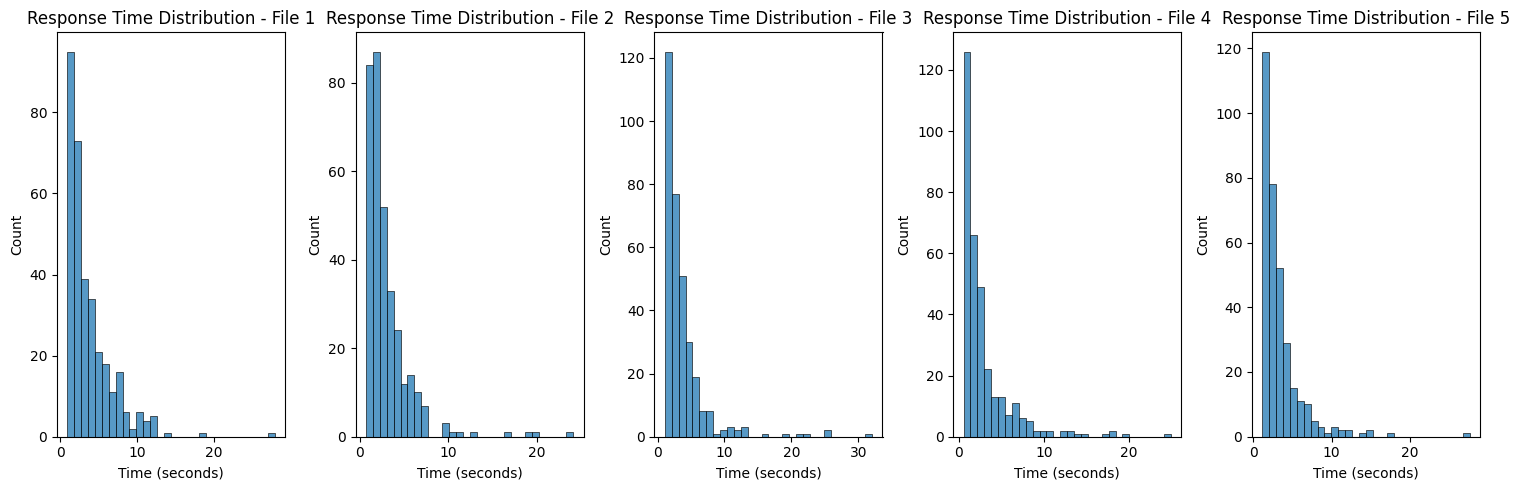

Total number of unique images (excluding attention checks): 200


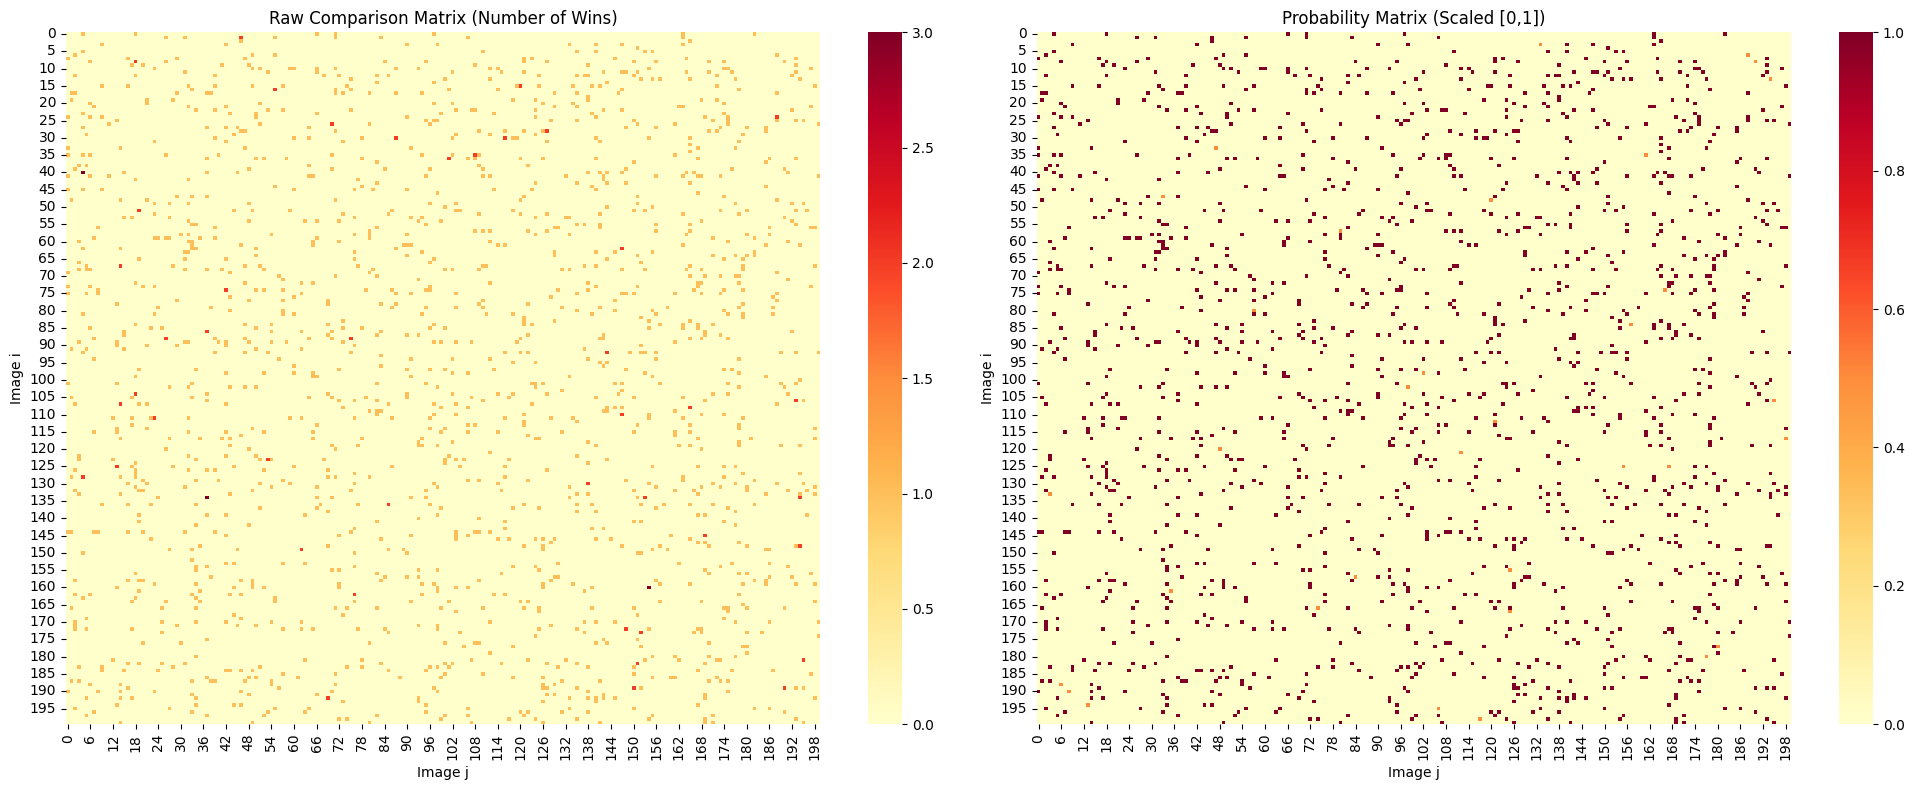


Comparison Matrix Statistics:
Total number of comparisons: 1667
Maximum wins for any pair: 3
Maximum win probability: 1.000
Average win probability (excluding zeros): 0.989


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

NO_CSV_FILES = 5

# Function to parse semicolon-separated strings into lists
def parse_list(x, convert_type=str):
    return [convert_type(i) for i in x.split(';')]

# Function to read and preprocess a CSV file
def read_and_preprocess(filename):
    df = pd.read_csv(filename)
    
    # Parse response times into lists of floats and convert to seconds
    df['response_times'] = df['response_times'].apply(lambda x: [float(t)/1000 for t in x.split(';')])
    
    # Parse other columns
    df['comparison_sequence'] = df['comparison_sequence'].apply(lambda x: [tuple(pair.split(',')) for pair in x.split(';')])
    df['comparison_responses'] = df['comparison_responses'].apply(parse_list, convert_type=int)
    df['selected_images'] = df['selected_images'].apply(parse_list)
    
    return df

# Read all six CSV files for semantic complexity
dfs = [read_and_preprocess(f"sem/{i}.csv") for i in range(1, NO_CSV_FILES+1)]

# 1. Plot distribution of response times
plt.figure(figsize=(15, 5))

for i, df in enumerate(dfs, 1):
    plt.subplot(1, NO_CSV_FILES, i)
    # Flatten the list of response times
    response_times = [time for times in df['response_times'] for time in times]
    
    sns.histplot(response_times, bins=30)
    plt.title(f'Response Time Distribution - File {i}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

# 2. Create comparison matrix
def get_all_image_ids(dfs):
    image_ids = set()
    for df in dfs:
        for comparisons in df['comparison_sequence']:
            for img1, img2 in comparisons:
                img1_id, img2_id = int(img1), int(img2)
                # Only add images that are not attention checks (-1 and 0)
                if img1_id > 0:
                    image_ids.add(img1_id)
                if img2_id > 0:
                    image_ids.add(img2_id)
    return sorted(list(image_ids))

# Get all unique image IDs and create a mapping
image_ids = get_all_image_ids(dfs)
id_to_index = {id_: idx for idx, id_ in enumerate(image_ids)}
num_images = len(image_ids)

print(f"Total number of unique images (excluding attention checks): {num_images}")

def update_comparison_matrix(matrix, total_matrix, comparisons, responses):
    """
    Update both the wins matrix and total comparisons matrix.
    
    Parameters:
    matrix: Matrix counting wins
    total_matrix: Matrix counting total comparisons between pairs
    comparisons: List of image pairs compared
    responses: List of responses (0 or 1)
    """
    for (img1, img2), response in zip(comparisons, responses):
        img1_id, img2_id = int(img1), int(img2)
        # Skip comparisons involving attention check images
        if img1_id <= 0 or img2_id <= 0:
            continue
        
        idx1, idx2 = id_to_index[img1_id], id_to_index[img2_id]
        if response == 0:  # First image won
            matrix[idx1][idx2] += 1
        else:  # Second image won
            matrix[idx2][idx1] += 1
            
        # Update total comparisons for this pair
        total_matrix[idx1][idx2] += 1
        total_matrix[idx2][idx1] += 1

# Initialize matrices
comparison_matrix = np.zeros((num_images, num_images), dtype=int)
total_comparisons_matrix = np.zeros((num_images, num_images), dtype=int)

# Update matrices with data from all files
for df in dfs:
    for comparisons, responses in zip(df['comparison_sequence'], df['comparison_responses']):
        update_comparison_matrix(comparison_matrix, total_comparisons_matrix, comparisons, responses)

# Create probability matrix (scaled to [0,1])
probability_matrix = np.zeros((num_images, num_images))
with np.errstate(divide='ignore', invalid='ignore'):  # Handle division by zero
    probability_matrix = comparison_matrix / total_comparisons_matrix
probability_matrix = np.nan_to_num(probability_matrix, 0)  # Replace NaN with 0

# Visualize both matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(comparison_matrix, cmap='YlOrRd', ax=ax1)
ax1.set_title('Raw Comparison Matrix (Number of Wins)')
ax1.set_xlabel('Image j')
ax1.set_ylabel('Image i')

sns.heatmap(probability_matrix, cmap='YlOrRd', ax=ax2)
ax2.set_title('Probability Matrix (Scaled [0,1])')
ax2.set_xlabel('Image j')
ax2.set_ylabel('Image i')

plt.tight_layout()
plt.show()

# Print some basic statistics
print("\nComparison Matrix Statistics:")
print(f"Total number of comparisons: {np.sum(total_comparisons_matrix)//2}")  # Divide by 2 as each comparison is counted twice
print(f"Maximum wins for any pair: {np.max(comparison_matrix)}")
print(f"Maximum win probability: {np.max(probability_matrix):.3f}")
print(f"Average win probability (excluding zeros): {np.mean(probability_matrix[probability_matrix > 0]):.3f}")

# Save the matrices
np.save("sem/npy/comparison_matrix.npy", comparison_matrix)
np.save("sem/npy/probability_matrix.npy", probability_matrix)
np.save("sem/npy/total_comparisons_matrix.npy", total_comparisons_matrix)
np.save("sem/npy/id_to_index.npy", id_to_index)

In [ ]:
def analyze_image_comparisons(image_id, dfs):
    print(f"\nAnalyzing comparisons for Image {image_id}:\n")
    print("Format: Image {image_id} vs Image X - Winner: Image Y")
    print("-" * 50)
    
    total_wins = 0
    total_losses = 0
    total_comparisons = 0
    
    for file_num, df in enumerate(dfs, 1):
        file_comparisons = 0
        print(f"\nFile {file_num}:")
        
        for comparisons, responses in zip(df['comparison_sequence'], df['comparison_responses']):
            for (img1, img2), response in zip(comparisons, responses):
                img1_id, img2_id = int(img1), int(img2)
                
                # Skip attention check images
                if img1_id <= 0 or img2_id <= 0:
                    continue
                
                # Check if our target image is involved in this comparison
                if img1_id == image_id or img2_id == image_id:
                    file_comparisons += 1
                    
                    # Determine winner
                    if img1_id == image_id:
                        opponent = img2_id
                        won = response == 0
                    else:  # img2_id == image_id
                        opponent = img1_id
                        won = response == 1
                    
                    winner = image_id if won else opponent
                    
                    if won:
                        total_wins += 1
                    else:
                        total_losses += 1
                    
                    print(f"Image {image_id} vs Image {opponent} - Winner: Image {winner}")
        
        if file_comparisons > 0:
            print(f"Total comparisons in file {file_num}: {file_comparisons}")
        else:
            print("No comparisons found in this file")
    
    total_comparisons = total_wins + total_losses
    
    print("\nSummary:")
    print("-" * 50)
    print(f"Total comparisons: {total_comparisons}")
    print(f"Wins: {total_wins}")
    print(f"Losses: {total_losses}")
    if total_comparisons > 0:
        win_rate = (total_wins / total_comparisons) * 100
        print(f"Win rate: {win_rate:.2f}%")



Analyzing comparisons for Image 2358947:

Format: Image {image_id} vs Image X - Winner: Image Y
--------------------------------------------------

File 1:
Image 2358947 vs Image 2410734 - Winner: Image 2358947
Image 2358947 vs Image 2410242 - Winner: Image 2358947
Total comparisons in file 1: 2

File 2:
Image 2358947 vs Image 2388442 - Winner: Image 2358947
Image 2358947 vs Image 2334660 - Winner: Image 2358947
Image 2358947 vs Image 2366422 - Winner: Image 2358947
Image 2358947 vs Image 2399197 - Winner: Image 2358947
Total comparisons in file 2: 4

File 3:
Image 2358947 vs Image 2361963 - Winner: Image 2358947
Image 2358947 vs Image 2320061 - Winner: Image 2358947
Image 2358947 vs Image 2352385 - Winner: Image 2358947
Image 2358947 vs Image 2371682 - Winner: Image 2358947
Total comparisons in file 3: 4

File 4:
Image 2358947 vs Image 2403091 - Winner: Image 2358947
Image 2358947 vs Image 4276 - Winner: Image 2358947
Image 2358947 vs Image 2355303 - Winner: Image 2358947
Image 23589

In [19]:
# Example usage - replace 1 with any image ID you want to analyze
analyze_image_comparisons(2395971, dfs)


Analyzing comparisons for Image 2395971:

Format: Image {image_id} vs Image X - Winner: Image Y
--------------------------------------------------

File 1:
Image 2395971 vs Image 2355303 - Winner: Image 2395971
Image 2395971 vs Image 2403091 - Winner: Image 2395971
Image 2395971 vs Image 2402692 - Winner: Image 2395971
Image 2395971 vs Image 2396053 - Winner: Image 2395971
Image 2395971 vs Image 2386942 - Winner: Image 2395971
Total comparisons in file 1: 5

File 2:
Image 2395971 vs Image 2322592 - Winner: Image 2395971
Image 2395971 vs Image 2402642 - Winner: Image 2395971
Total comparisons in file 2: 2

File 3:
Image 2395971 vs Image 2343496 - Winner: Image 2395971
Image 2395971 vs Image 2402692 - Winner: Image 2395971
Image 2395971 vs Image 2342911 - Winner: Image 2395971
Total comparisons in file 3: 3

File 4:
Image 2395971 vs Image 2318319 - Winner: Image 2395971
Total comparisons in file 4: 1

File 5:
Image 2395971 vs Image 2339617 - Winner: Image 2395971
Image 2395971 vs Image 

In [3]:
# measure the correlation between different methods

df1 = pd.read_csv("bradley_terry_rankings_lsr.csv")
df2 = pd.read_csv("bradley_terry_rankings_mm.csv")
df3 = pd.read_csv("bradley_terry_rankings_opt.csv")

sr_1 = df1['standardized_rating']
sr_2 = df2['standardized_rating']
sr_3 = df3['standardized_rating']

# Calculate correlation between the three methods
correlation_1_2 = np.corrcoef(sr_1, sr_2)[0, 1]
correlation_1_3 = np.corrcoef(sr_1, sr_3)[0, 1]
correlation_2_3 = np.corrcoef(sr_2, sr_3)[0, 1]

print(f"Correlation between LSR and MM: {correlation_1_2:.2f}")
print(f"Correlation between LSR and OPT: {correlation_1_3:.2f}")
print(f"Correlation between MM and OPT: {correlation_2_3:.2f}")


Correlation between LSR and MM: 1.00
Correlation between LSR and OPT: 1.00
Correlation between MM and OPT: 1.00


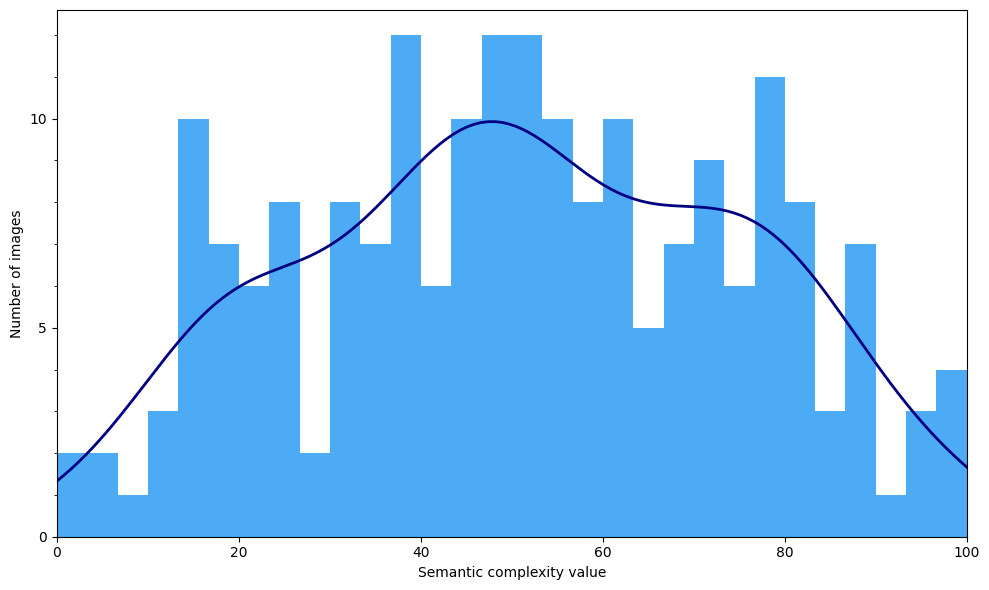

Correlation between:
normalized_rating and # of SAM 2 segmentations:  0.1930968920792641
normalized_rating and # of SAM segmentations:  0.20531253793228618
normalized_rating and # of FC-CLIP segmentations:  0.30016831948755274
normalized_rating and # of VG objects:  0.22345406440333615
normalized_rating and average object dissimilarity:  0.15815963192048402
normalized_rating and average region dissimilarity:  0.40120723153917787
normalized_rating and average relationship dissimilarity:  0.35562254063909926
normalized_rating and average autoregressive surprisal:  0.16931842344391962
normalized_rating and IC9600 predictions:  0.3277499311856247


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read the data
df = pd.read_csv('bradley_terry_rankings_mm.csv')
feature = "normalized_rating"

# Scale the ratings to 0-100 range
normalized_rating = df[feature] * 100

# Create figure and axis
plt.figure(figsize=(10, 6))

# Plot histogram without density normalization
n, bins, patches = plt.hist(normalized_rating, bins=30, color='#2196F3', alpha=0.8, density=False)

# Add kernel density estimate scaled to match histogram height
kde_factor = len(normalized_rating) * (bins[1] - bins[0])
kde = sns.kdeplot(data=normalized_rating, color='navy', linewidth=2)
line = kde.lines[0]
line.set_data(line.get_data()[0], line.get_data()[1] * kde_factor)

# Set x-axis limits to 0-100
plt.xlim(0, 100)

# Set y-axis to show only integer values
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(5))  # Set major ticks every 5 units
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(1))  # Set minor ticks every 1 unit

# Customize the plot
plt.xlabel('Semantic complexity value')
plt.ylabel('Number of images')
plt.grid(False)

# Set background color to white
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
# save ranks to csv with 4 points after decimal
df[feature] = normalized_rating.round(4)

# read features.csv
df_feat = pd.read_csv('features.csv')

# take only the images that are in the bradley_terry_rankings_mm.csv
image_ids = df['image_id'].values

# filter the features dataframe
df_feat = df_feat[df_feat['image_id'].isin(image_ids)]

# merge the two dataframes
# Add only the specific feature column from df to df_feat
df_feat = df_feat.merge(df[['image_id', feature]], on='image_id')


# get correlation of all features on a heatmap
# create a heatmap of correlations between all features
df_feat["avg_object_similarity"] *= -1
df_feat["avg_region_similarity"] *= -1
df_feat["avg_rel_similarity"] *= -1

def print_cors(df_feat):
    print("Correlation between:")
    print(f"{feature} and # of SAM 2 segmentations: ", df_feat[feature].corr(df_feat['# of SAM 2 segmentations'], method='spearman'))
    print(f"{feature} and # of SAM segmentations: ", df_feat[feature].corr(df_feat['# of SAM segmentations'], method='spearman'))
    print(f"{feature} and # of FC-CLIP segmentations: ", df_feat[feature].corr(df_feat['# of FC-CLIP classes'], method='spearman'))
    print(f"{feature} and # of VG objects: ", df_feat[feature].corr(df_feat['# of objects'], method='spearman'))
    print(f"{feature} and average object dissimilarity: ", df_feat[feature].corr(df_feat['avg_object_similarity'], method='spearman'))
    print(f"{feature} and average region dissimilarity: ", df_feat[feature].corr(df_feat['avg_region_similarity'], method='spearman'))
    print(f"{feature} and average relationship dissimilarity: ", df_feat[feature].corr(df_feat['avg_rel_similarity'], method='spearman'))
    print(f"{feature} and average autoregressive surprisal: ", df_feat[feature].corr(df_feat['average autoregressive surprisal'], method='spearman'))
    print(f"{feature} and IC9600 predictions: ", df_feat[feature].corr(df_feat['predicted_complexity'], method='spearman'))
    
    
print_cors(df_feat)


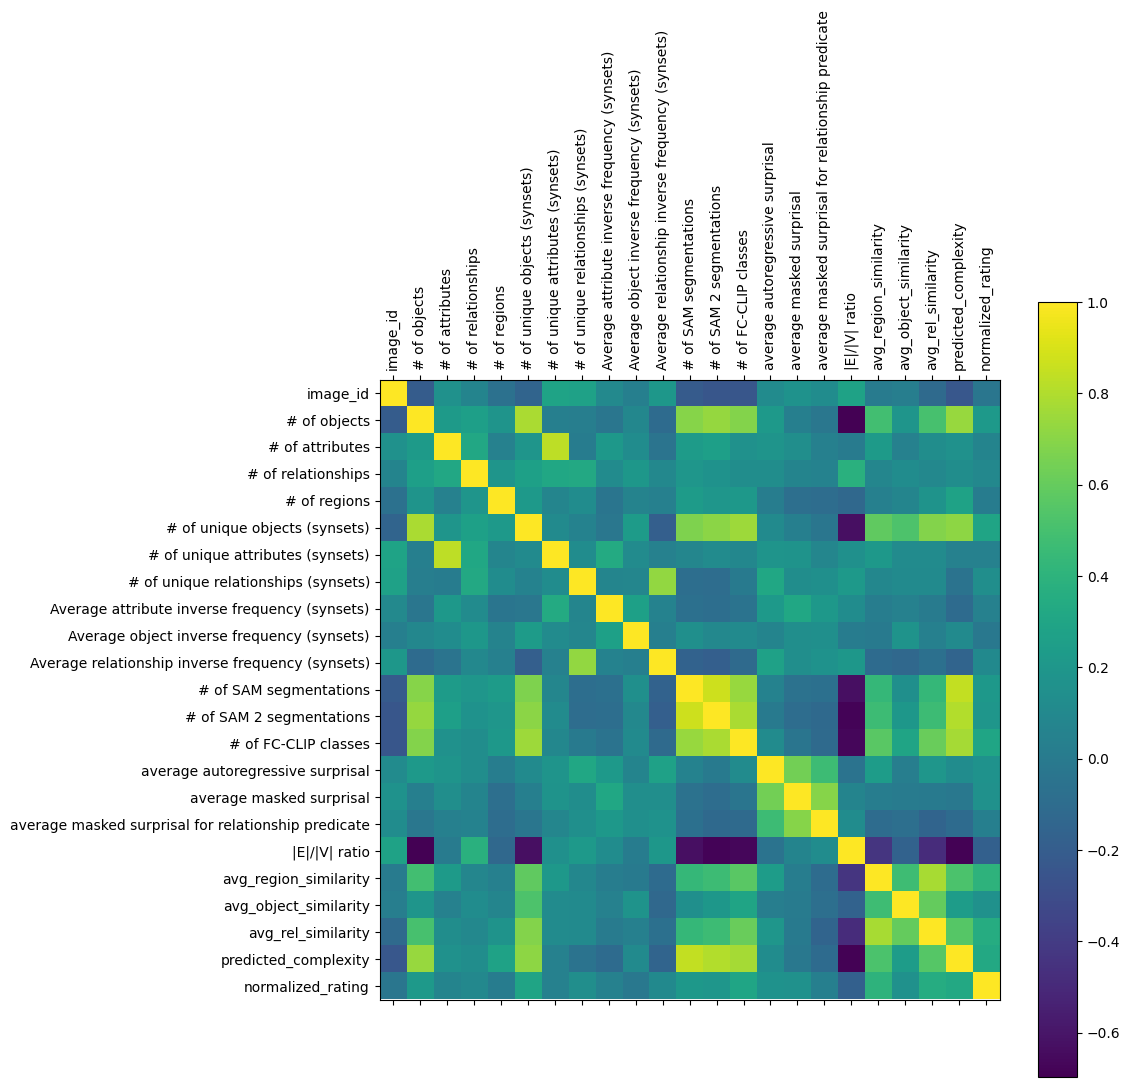

In [7]:
# put feature labels
corr = df_feat.corr(method='spearman')
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.matshow(corr, fignum=1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()

In [8]:
# save df as 
df_feat.to_csv('sem_features.csv', index=False)

In [10]:
sem_features = pd.read_csv('sem/sem_features.csv')
vis_features = pd.read_csv('vis/vis_features.csv')

images = sem_features['image_id']

sem_ratings = []
vis_ratings = []

for image in images:
    sem_ratings.append(sem_features[sem_features['image_id'] == image]['normalized_rating'].values[0])
    vis_ratings.append(vis_features[vis_features['image_id'] == image]['normalized_rating'].values[0])

# calculate spearman correlation

from scipy.stats import spearmanr
correlation, _ = spearmanr(sem_ratings, vis_ratings)
print(f"Spearman correlation between semantic and visual complexity: {correlation:.3f}")

Spearman correlation between semantic and visual complexity: 0.432


In [18]:
def find_significants(df):
    # get p values
    p_values = df['p_value']

    # count number of p values less than 0.05
    significant_p_values = (p_values < 0.05).sum()
    total_p_values = len(p_values)
    print(f"Number of significant p-values: {significant_p_values} out of {total_p_values} ({significant_p_values/total_p_values:.2f})")

# read vis/bradley_terry_rankings_lsr.csv

df_vis = pd.read_csv('vis/bradley_terry_rankings_lsr.csv')
df_sem = pd.read_csv('sem/bradley_terry_rankings_lsr.csv')
print("Visual complexity:")
find_significants(df_vis)

print("\nSemantic complexity:")
find_significants(df_sem)

Visual complexity:
Number of significant p-values: 146 out of 200 (0.73)

Semantic complexity:
Number of significant p-values: 1 out of 200 (0.01)
